#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

#### Load Daatsets

In [3]:
train_path = "artifacts/data_ingestion/mental_health_dataset.csv"
test_path = "artifacts/data_ingestion/mental_health_dataset_test.csv"

In [4]:
traindata = pd.read_csv(train_path)
testdata = pd.read_csv(test_path)
print(f"Training data shape: {traindata.shape}")
print(f"Test data shape: {testdata.shape}")

Training data shape: (140700, 20)
Test data shape: (93800, 19)


In [5]:
# Display the first few rows of the training data
print("\nFirst 5 rows of the training dataset:")
traindata.head()


First 5 rows of the training dataset:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [6]:
# Check data types and missing values
print("\nData types and non-null counts:")
traindata.info()



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction     

#### Data Visualization

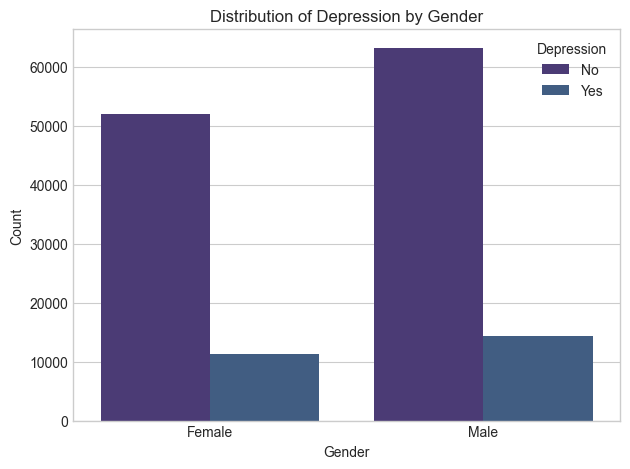

In [8]:
# Distribution of Depression by Gender
plt.figure()
sns.countplot(x='Gender', hue='Depression', data=traindata)
plt.title('Distribution of Depression by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Depression', labels=['No', 'Yes'])
plt.tight_layout()

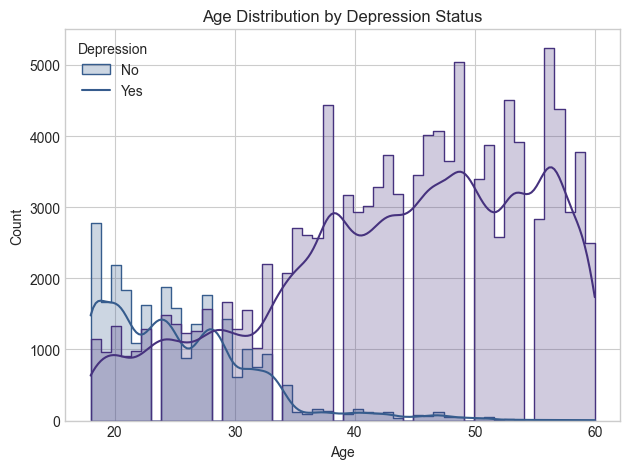

In [11]:
# Age distribution by Depression status
plt.figure()
sns.histplot(data=traindata, x='Age', hue='Depression', kde=True, element='step', common_norm=False)
plt.title('Age Distribution by Depression Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Depression', labels=['No', 'Yes'])
plt.tight_layout()  

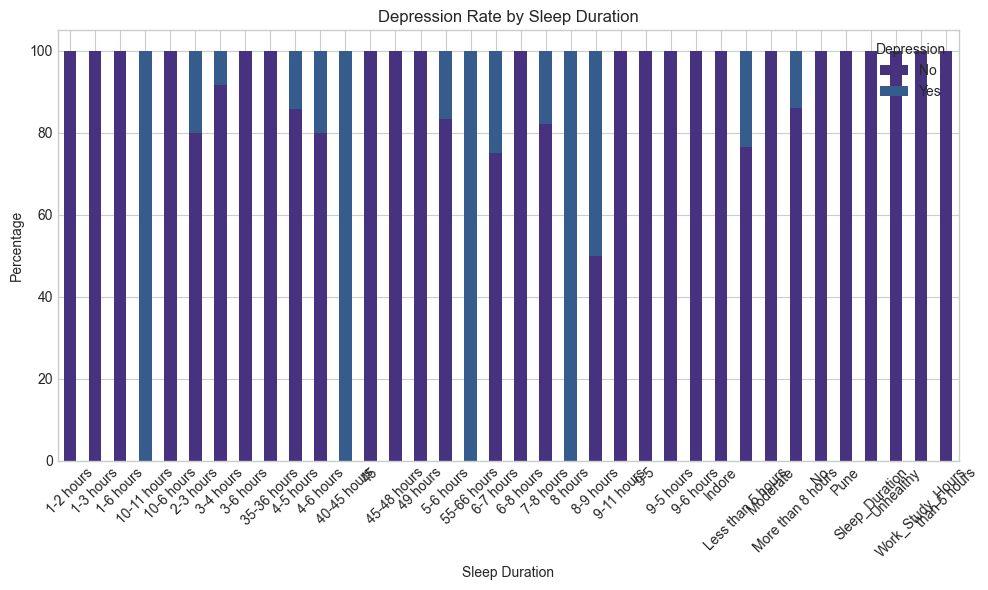

In [12]:
# Sleep Duration vs Depression
sleep_depression = pd.crosstab(traindata['Sleep Duration'], traindata['Depression'])
sleep_depression_pct = sleep_depression.div(sleep_depression.sum(axis=1), axis=0) * 100
ax = sleep_depression_pct.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Depression Rate by Sleep Duration')
ax.set_xlabel('Sleep Duration')
ax.set_ylabel('Percentage')
ax.legend(title='Depression', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


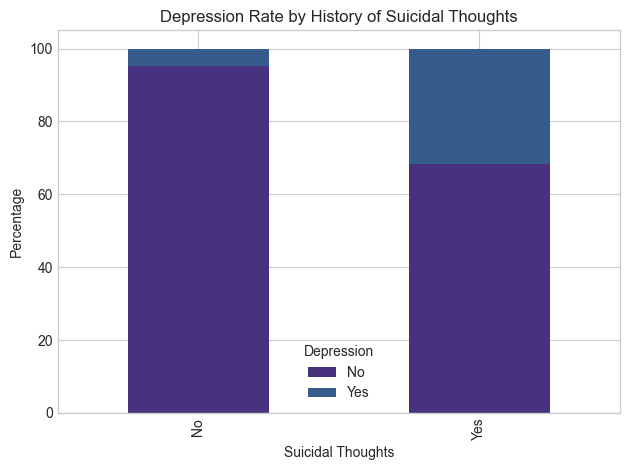

In [16]:
# Suicidal Thoughts vs Depression

thoughts_depression = pd.crosstab(traindata['Have you ever had suicidal thoughts ?'], traindata['Depression'])
thoughts_depression_pct = thoughts_depression.div(thoughts_depression.sum(axis=1), axis=0) * 100
thoughts_depression_pct.plot(kind='bar', stacked=True)
plt.title('Depression Rate by History of Suicidal Thoughts')
plt.xlabel('Suicidal Thoughts')
plt.ylabel('Percentage')
plt.legend(title='Depression', labels=['No', 'Yes'])
plt.tight_layout()

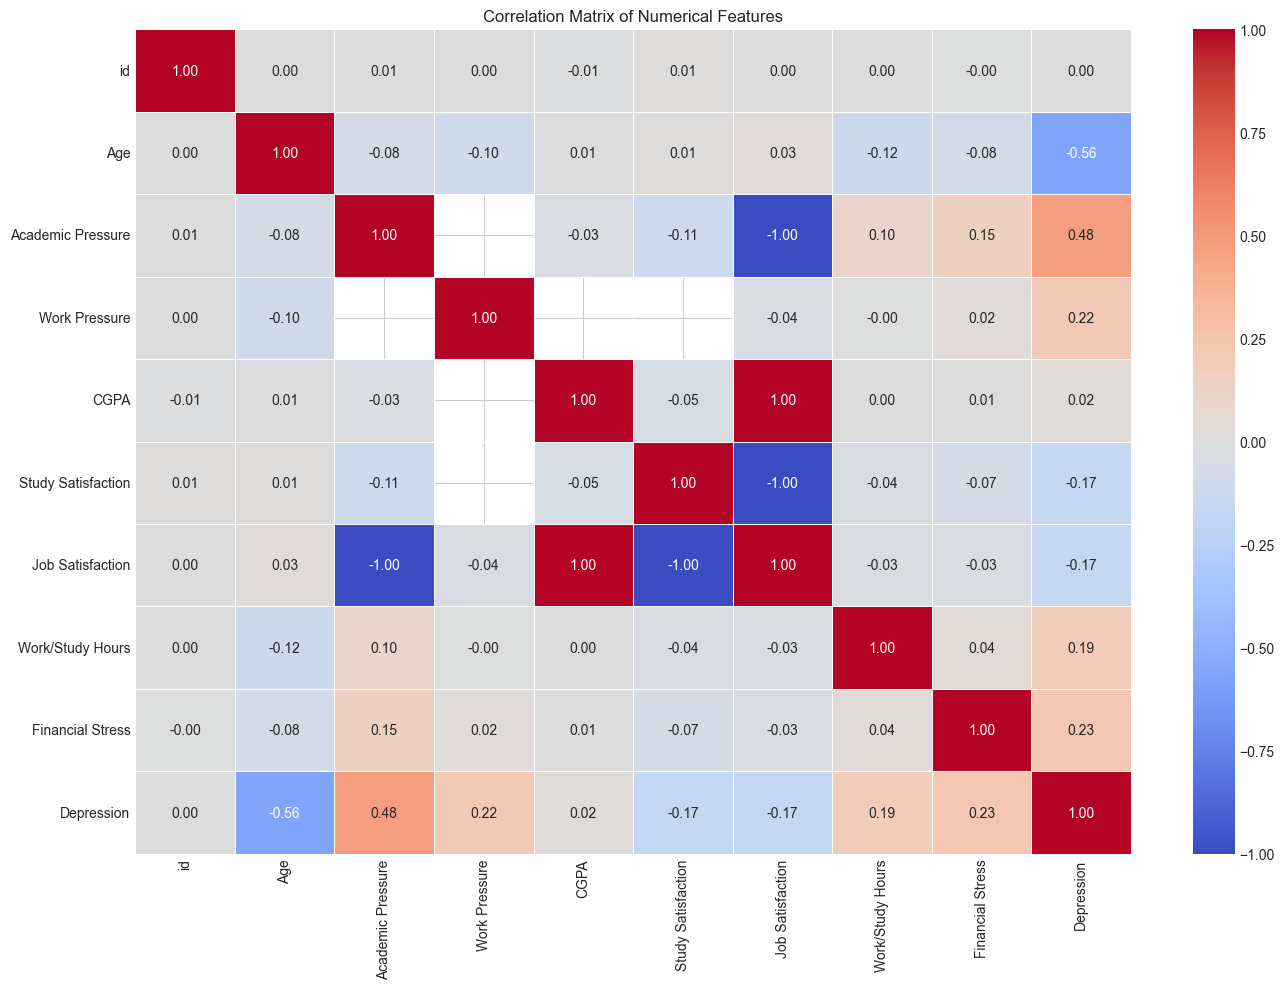

In [19]:
# Correlation Matrix (HeatMap)
plt.figure(figsize=(14, 10))

numeric_columns = traindata.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = traindata[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()

#### Data Preprocessing

In [20]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [22]:
# Handle Students with missing Profession
students = traindata[traindata['Working Professional or Student'] == 'Student']
print(f"Number of students with non-null profession: {students["Profession"].notna().sum()}")

Number of students with non-null profession: 34


In [23]:
# Fill missing profession values for students
traindata.loc[(traindata['Working Professional or Student'] == 'Student') & 
              (traindata['Profession'].isna()), 'Profession'] = 'Student'
testdata.loc[(testdata['Working Professional or Student'] == 'Student') & 
             (testdata['Profession'].isna()), 'Profession'] = 'Student'

In [24]:
# Drop the 'Working Professional or Student' column as it's redundant now
traindata = traindata.drop(columns=['Working Professional or Student'])
testdata = testdata.drop(columns=['Working Professional or Student'])

In [25]:
# Combine Academic and Work Pressure into a single feature
traindata['Pressure'] = traindata.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) 
               else (row['Work Pressure'] if pd.notna(row['Work Pressure']) and pd.isna(row['Academic Pressure']) 
               else (row[['Academic Pressure', 'Work Pressure']].mean() if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) 
               else None)), axis=1)

testdata['Pressure'] = testdata.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) 
               else (row['Work Pressure'] if pd.notna(row['Work Pressure']) and pd.isna(row['Academic Pressure']) 
               else (row[['Academic Pressure', 'Work Pressure']].mean() if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) 
               else None)), axis=1)

In [26]:
# Drop the original pressure columns
traindata = traindata.drop(columns=['Academic Pressure', 'Work Pressure'])
testdata = testdata.drop(columns=['Academic Pressure', 'Work Pressure'])

In [27]:
# Combine Study and Job Satisfaction into a single feature
traindata['Satisfaction'] = traindata.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) 
               else (row['Job Satisfaction'] if pd.notna(row['Job Satisfaction']) and pd.isna(row['Study Satisfaction']) 
               else (row[['Study Satisfaction', 'Job Satisfaction']].mean() if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) 
               else None)), axis=1)

testdata['Satisfaction'] = testdata.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) 
               else (row['Job Satisfaction'] if pd.notna(row['Job Satisfaction']) and pd.isna(row['Study Satisfaction']) 
               else (row[['Study Satisfaction', 'Job Satisfaction']].mean() if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) 
               else None)), axis=1)

In [28]:
# Drop the original satisfaction columns
traindata = traindata.drop(columns=['Study Satisfaction', 'Job Satisfaction'])
testdata = testdata.drop(columns=['Study Satisfaction', 'Job Satisfaction'])

In [29]:
# Drop unnecessary columns
columns_to_drop = ['Name', 'City', 'Profession', 'CGPA', 'Degree']
traindata = traindata.drop(columns=columns_to_drop)
testdata = testdata.drop(columns=columns_to_drop)

In [30]:
# Convert Sleep Duration to numeric values
print("\nUnique values in Sleep Duration:")
print(traindata['Sleep Duration'].unique())

def convert_sleep_duration(duration):
    if duration in ['More than 8 hours', '7-8 hours', '6-8 hours', '10-11 hours', '8-9 hours', 
                  '9-11 hours', '8 hours', '55-66 hours', '9-6 hours', '49 hours', '45-48 hours']:
        return 3
    elif duration in ['Less than 5 hours', '1-2 hours', '2-3 hours', '3-4 hours', '4-5 hours', 
                    '1-3 hours', 'No', '35-36 hours', '45', '1-6 hours', 'Unhealthy']:
        return 1
    else:
        return 2


Unique values in Sleep Duration:
['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 'Sleep_Duration' '1-2 hours' '6-8 hours' '4-6 hours' '6-7 hours'
 '10-11 hours' '8-9 hours' '40-45 hours' '9-11 hours' '2-3 hours'
 '3-4 hours' 'Moderate' '55-66 hours' '4-5 hours' '9-6 hours' '1-3 hours'
 'Indore' '45' '1-6 hours' '35-36 hours' '8 hours' 'No' '10-6 hours'
 'than 5 hours' '49 hours' 'Unhealthy' 'Work_Study_Hours' '3-6 hours'
 '45-48 hours' '9-5' 'Pune' '9-5 hours']


In [31]:
traindata['Sleep Duration Numeric'] = traindata['Sleep Duration'].apply(convert_sleep_duration)
testdata['Sleep Duration Numeric'] = testdata['Sleep Duration'].apply(convert_sleep_duration)

In [32]:
print("\nSleep Duration converted to numeric values:")
print(traindata['Sleep Duration Numeric'].value_counts())


Sleep Duration converted to numeric values:
Sleep Duration Numeric
3    69710
1    38823
2    32167
Name: count, dtype: int64


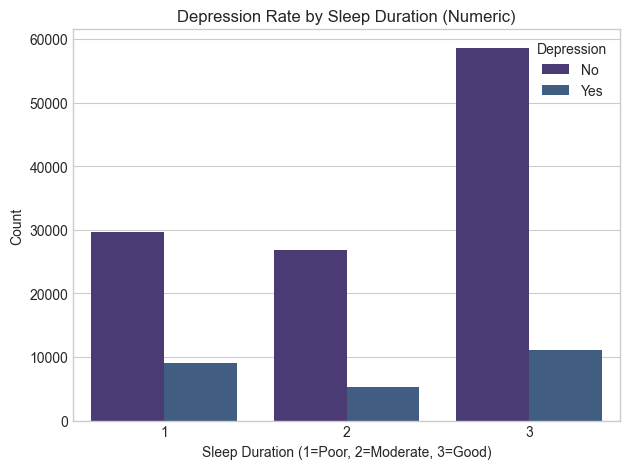

In [33]:
# Visualize sleep duration distribution after converion into numeric values
plt.figure()
sns.countplot(x='Sleep Duration Numeric', hue='Depression', data=traindata)
plt.title('Depression Rate by Sleep Duration (Numeric)')
plt.xlabel('Sleep Duration (1=Poor, 2=Moderate, 3=Good)')
plt.ylabel('Count')
plt.legend(title='Depression', labels=['No', 'Yes'])
plt.tight_layout()

In [34]:
# Drop the original Sleep Duration column
traindata = traindata.drop(columns=['Sleep Duration'])
testdata = testdata.drop(columns=['Sleep Duration'])

In [37]:
# Convert Dietary Habits to numeric values
print("\nUnique values in Dietary Habits:")
print(traindata['Dietary Habits'].unique())

def convert_dietary_habits(habits):
    if habits in ['Healthy', 'Yes', '3', 'More Healthy']:
        return 3
    elif habits in ['Unhealthy', '1.0', 'No Healthy', 'No']:
        return 1
    else:
        return 2



Unique values in Dietary Habits:
['Healthy' 'Unhealthy' 'Moderate' 'Yes' 'Pratham' 'BSc' 'Gender' '3'
 'More Healthy' 'Less than Healthy' 'Mihir' '1.0' 'Hormonal' 'Electrician'
 nan 'No Healthy' 'Less Healthy' 'M.Tech' 'Vegas' 'No' 'Male' 'Indoor'
 'Class 12' '2']


In [38]:
traindata['Dietary Habits Numeric'] = traindata['Dietary Habits'].apply(convert_dietary_habits)
testdata['Dietary Habits Numeric'] = testdata['Dietary Habits'].apply(convert_dietary_habits)

In [40]:
print("\nDietary Habits converted to numeric values:")
print(traindata['Dietary Habits Numeric'].value_counts())


Dietary Habits converted to numeric values:
Dietary Habits Numeric
2    49723
1    46231
3    44746
Name: count, dtype: int64


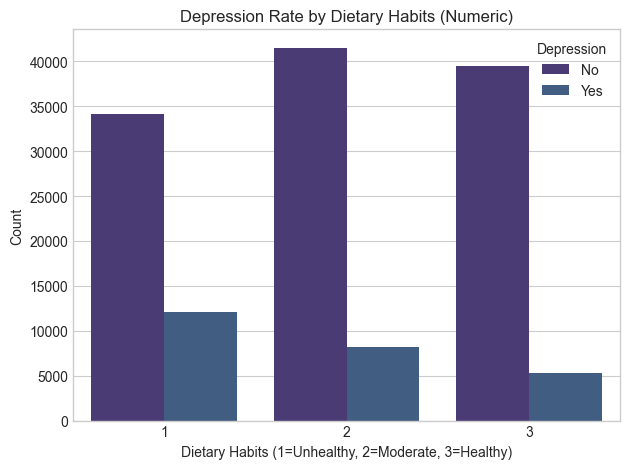

In [43]:
# Visualize dietary habits distribution after conversion into numeric
plt.figure()
sns.countplot(x='Dietary Habits Numeric', hue='Depression', data=traindata)
plt.title('Depression Rate by Dietary Habits (Numeric)')
plt.xlabel('Dietary Habits (1=Unhealthy, 2=Moderate, 3=Healthy)')
plt.ylabel('Count')
plt.legend(title='Depression', labels=['No', 'Yes'])
plt.tight_layout()

In [44]:
# Drop the original Dietary Habits column
traindata = traindata.drop(columns=['Dietary Habits'])
testdata = testdata.drop(columns=['Dietary Habits'])

In [45]:
# Convert categorical variables to numeric
traindata['Gender'] = traindata['Gender'].map({'Male': 0, 'Female': 1})
testdata['Gender'] = testdata['Gender'].map({'Male': 0, 'Female': 1})

In [46]:
traindata['Have you ever had suicidal thoughts ?'] = traindata['Have you ever had suicidal thoughts ?'].map({'No': 0, 'Yes': 1})
testdata['Have you ever had suicidal thoughts ?'] = testdata['Have you ever had suicidal thoughts ?'].map({'No': 0, 'Yes': 1})

In [47]:
traindata['Family History of Mental Illness'] = traindata['Family History of Mental Illness'].map({'No': 0, 'Yes': 1})
testdata['Family History of Mental Illness'] = testdata['Family History of Mental Illness'].map({'No': 0, 'Yes': 1})

In [48]:
# Handle missing values
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 12 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Gender                                 140700 non-null  int64  
 2   Age                                    140700 non-null  float64
 3   Have you ever had suicidal thoughts ?  140700 non-null  int64  
 4   Work/Study Hours                       140700 non-null  float64
 5   Financial Stress                       140696 non-null  float64
 6   Family History of Mental Illness       140700 non-null  int64  
 7   Depression                             140700 non-null  int64  
 8   Pressure                               140679 non-null  float64
 9   Satisfaction                           140685 non-null  float64
 10  Sleep Duration Numeric                 140700 non-null  

In [49]:
# Fill the missing values with median after conversion
traindata['Financial Stress'].fillna(traindata['Financial Stress'].median(), inplace=True)
traindata['Pressure'].fillna(traindata['Pressure'].median(), inplace=True)
traindata['Satisfaction'].fillna(traindata['Satisfaction'].median(), inplace=True)

testdata['Financial Stress'].fillna(testdata['Financial Stress'].median(), inplace=True)
testdata['Pressure'].fillna(testdata['Pressure'].median(), inplace=True)
testdata['Satisfaction'].fillna(testdata['Satisfaction'].median(), inplace=True)

In [50]:
traindata.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Pressure                                 0
Satisfaction                             0
Sleep Duration Numeric                   0
Dietary Habits Numeric                   0
dtype: int64

<Figure size 1400x1000 with 0 Axes>

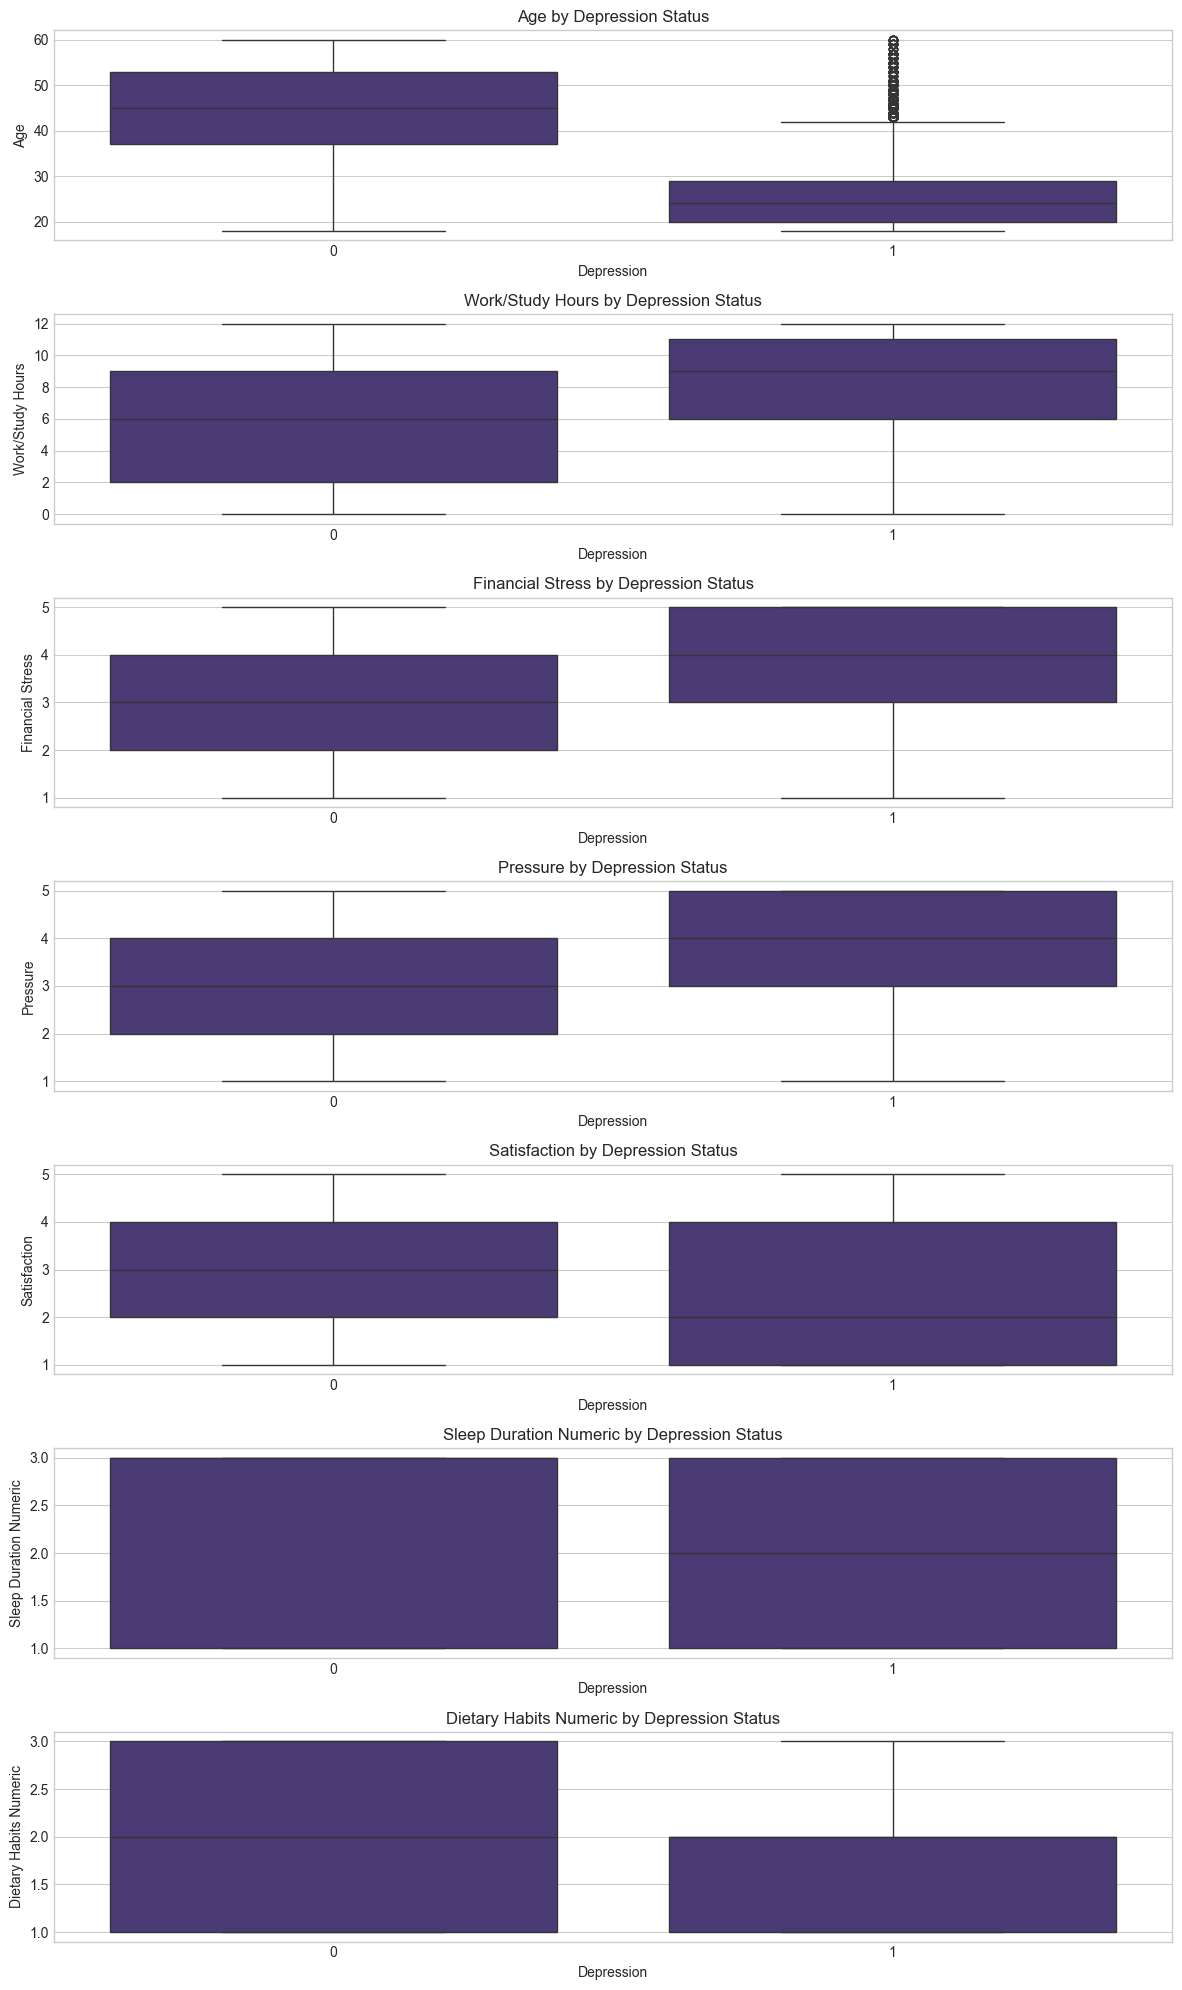

In [55]:
# Create a boxplot to see the relationship between features and depression
plt.figure(figsize=(14, 10))
features_to_plot = ['Age', 'Work/Study Hours', 'Financial Stress', 'Pressure', 
                   'Satisfaction', 'Sleep Duration Numeric', 'Dietary Habits Numeric']
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(12, 20))
for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='Depression', y=feature, data=traindata, ax=axes[i])
    axes[i].set_title(f'{feature} by Depression Status')
    axes[i].set_xlabel('Depression')
    axes[i].set_ylabel(feature)

plt.tight_layout()

#### Data Preparation for Modeling

In [57]:
traindata.head()

,id,Gender,Age,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction,Sleep Duration Numeric,Dietary Habits Numeric
0,0,1,49.0,0,1.0,2.0,0,0,5.0,2.0,3,3
1,1,0,26.0,1,7.0,3.0,0,1,4.0,3.0,1,1
2,2,0,33.0,1,3.0,1.0,0,1,5.0,2.0,2,3
3,3,0,22.0,1,10.0,1.0,1,1,5.0,1.0,1,2
4,4,1,30.0,1,9.0,4.0,1,0,1.0,1.0,2,1


,id,Gender,Age,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Pressure,Satisfaction,Sleep Duration Numeric,Dietary Habits Numeric
0,140700,0,53.0,0,9.0,3.0,1,2.0,5.0,1,2
1,140701,1,58.0,0,6.0,4.0,0,2.0,4.0,1,2
2,140702,0,53.0,1,12.0,4.0,0,4.0,1.0,3,2
3,140703,1,23.0,1,10.0,4.0,0,5.0,1.0,3,2
4,140704,0,47.0,1,3.0,4.0,0,5.0,5.0,3,2
...,...,...,...,...,...,...,...,...,...,...,...
93795,234495,1,49.0,1,2.0,2.0,1,3.0,5.0,1,2
93796,234496,0,29.0,1,11.0,3.0,1,5.0,1.0,3,2
93797,234497,0,24.0,0,7.0,1.0,0,1.0,4.0,3,2
93798,234498,1,23.0,1,7.0,5.0,1,4.0,2.0,2,3


In [79]:
final_data = traindata.copy()
final_data.drop(['id'], axis=1, inplace=True)
final_data.to_csv("artifacts/data_ingestion/final_data.csv", index=False)


In [56]:
# Prepare the data for modeling
X = traindata.drop(['Depression', 'id'], axis=1)
y = traindata.Depression

In [61]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [62]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (98490, 10)
Test data shape: (42210, 10)


In [63]:
# from xgboost.sklearn import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# model = XGBClassifier(objective='binary:logistic', nthread=4, seed=0)

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0, 0.1, 0.5],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'reg_alpha': [0, 0.005, 0.1]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parametrs:", grid_search.best_params_)
# print("Best accurecy:", grid_search.best_score_)

In [64]:
# Train the XGBoost model
model = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=5,
    gamma=0,
    subsample=0.5,
    colsample_bytree=0.8,
    reg_alpha=0.005,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=0
)

In [65]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, nthread=4, ...)

In [66]:
# Make predictions
y_pred = model.predict(X_test)

In [67]:
# Evaluate the model
print("\nModel Evaluation:")
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')


Model Evaluation:
Accuracy: 0.9320
Precision: 0.8218
Recall: 0.7974
F1 Score: 0.8094


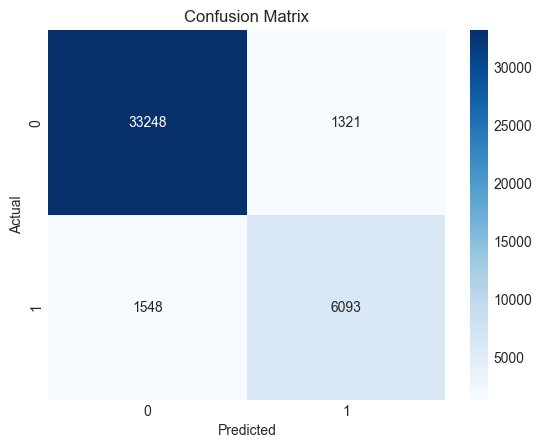

In [72]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Text(0.5, 0, 'Importance')

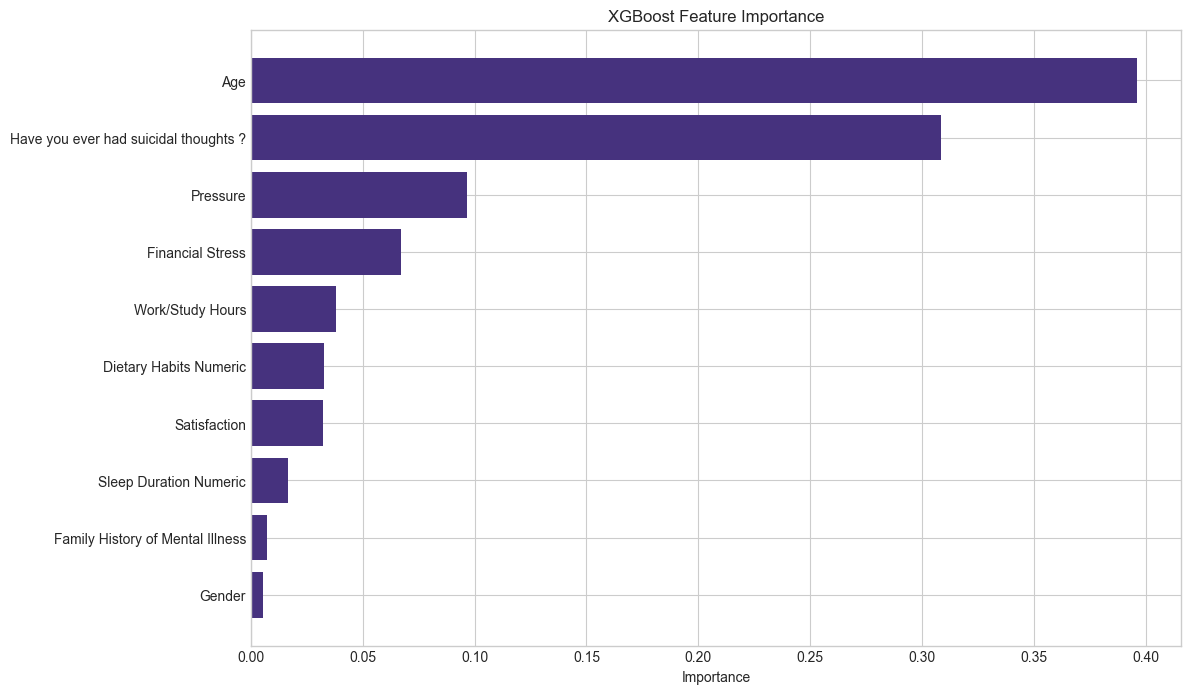

In [73]:
# Feature importance
plt.figure(figsize=(12, 8))
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')

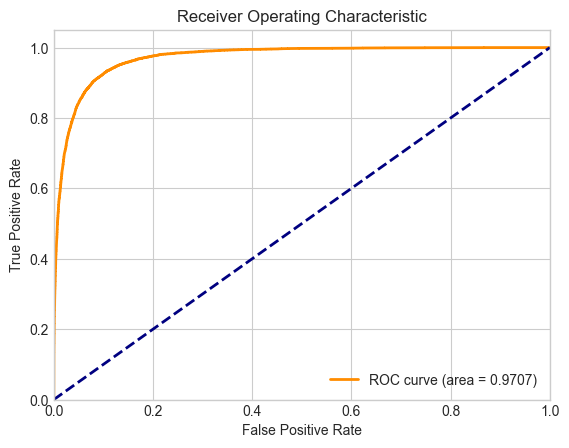

In [75]:
# Final visualization: ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")